# Homework Response for Intro. to Neural Networks

## imports from lesson notebook

In [1]:
%matplotlib inline

import torch
import torchvision
from torch import nn

import numpy 
import matplotlib.pyplot as plt
import time

In [2]:
training_data = torchvision.datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

test_data = torchvision.datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [3]:
# randomly split the training data to training data and validation data
training_data, validation_data = torch.utils.data.random_split(training_data, [0.8, 0.2], generator=torch.Generator().manual_seed(55))

In [4]:
print('MNIST data loaded: train:',len(training_data),' examples, validation: ', len(validation_data), 'examples, test:',len(test_data), 'examples')
print('Input shape', training_data[0][0].shape)

MNIST data loaded: train: 48000  examples, validation:  12000 examples, test: 10000 examples
Input shape torch.Size([1, 28, 28])


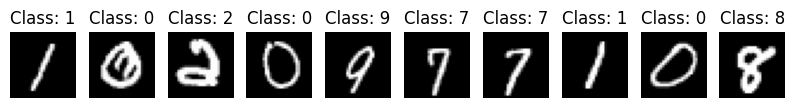

In [5]:
# printed first 10 items of the training dataset
pltsize=1
plt.figure(figsize=(10*pltsize, pltsize))

for i in range(10):
    plt.subplot(1,10,i+1)
    plt.axis('off')
    plt.imshow(numpy.reshape(training_data[i][0], (28, 28)), cmap="gray")
    plt.title('Class: '+str(training_data[i][1]))

In [6]:
batch_size = 128

# The dataloader makes our dataset iterable 
train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=batch_size)
val_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size)

### learning imports

In [7]:
def train_one_epoch(dataloader, model, loss_fn, optimizer):
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # forward pass
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backward pass calculates gradients
        loss.backward()
        
        # take one step with these gradients
        optimizer.step()
        
        # resets the gradients 
        optimizer.zero_grad()

In [8]:
def evaluate(dataloader, model, loss_fn):
    # Set the model to evaluation mode - some NN pieces behave differently during training
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    # We can save computation and memory by not calculating gradients here - we aren't optimizing 
    with torch.no_grad():
        # loop over all of the batches
        for X, y in dataloader:
            pred = model(X)
            loss += loss_fn(pred, y).item()
            # how many are correct in this batch? Tracking for accuracy 
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    correct /= size
    
    accuracy = 100*correct
    return accuracy, loss

### nonlinear model import

In [24]:
class NonlinearClassifier(nn.Module):
    # notes:
    # for the nn.Linear method, one of the arguments is 28*28 - this indicates the size of the image. 
    #
    # for the second argument the number, 50 was arbitrary, and it represents the width of the layer 
    # in the neural network.
    #
    # for the last nn.Linear method, the second argument is 10 because that is the output layer that contains
    # the probabilities of all of the 10 classes of classifiers

    def __init__(self):
        super().__init__()
        # flatten data into single vector
        self.flatten = nn.Flatten()
        self.layers_stack = nn.Sequential(
            # think of the linear and relu methods as one layer in the neural network
            # conducts matrix multiplication and adds a vector
            nn.Linear(28*28, 75),
            # make nonlinear
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(75, 100),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(100, 75),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(75, 10)
        )
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.layers_stack(x)

        return x

### inference imports

In [25]:
def show_failures(model, dataloader, maxtoshow=10):
    model.eval()
    batch = next(iter(dataloader))
    predictions = model(batch[0])
    
    rounded = predictions.argmax(1)
    errors = rounded!=batch[1]
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parentheses.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(batch[0].shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            plt.imshow(batch[0][i,0,:,:], cmap="gray")
            plt.title("%d (%d)" % (rounded[i], batch[1][i]))
            ii = ii + 1

## my code

In [26]:
# create test data loader from the variables defined in the imports section
# in this case the batch_size variable is set to 128 items
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [27]:
# prep the nonlinear model
nonlinear_model = NonlinearClassifier()
print(nonlinear_model)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(nonlinear_model.parameters(), lr=0.01)

NonlinearClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers_stack): Sequential(
    (0): Linear(in_features=784, out_features=75, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=75, out_features=100, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=100, out_features=75, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=75, out_features=10, bias=True)
  )
)


### training

In [29]:
%%time

epochs = 30
for j in range(epochs):
    train_one_epoch(train_dataloader, nonlinear_model, loss_fn, optimizer)
    
    # checking on the training loss and accuracy once per epoch
    acc, loss = evaluate(train_dataloader, nonlinear_model, loss_fn)
    print(f"Epoch {j}: training loss: {loss}, accuracy: {acc}")

Epoch 0: training loss: 0.22975279219945272, accuracy: 93.35833333333333
Epoch 1: training loss: 0.22187444752454757, accuracy: 93.54791666666667
Epoch 2: training loss: 0.21387542663017908, accuracy: 93.76875
Epoch 3: training loss: 0.20748182721932729, accuracy: 93.93125
Epoch 4: training loss: 0.19995890947182973, accuracy: 94.20625
Epoch 5: training loss: 0.19323556741078696, accuracy: 94.4125
Epoch 6: training loss: 0.18735939023892084, accuracy: 94.64375000000001
Epoch 7: training loss: 0.1813405837317308, accuracy: 94.79583333333333
Epoch 8: training loss: 0.17633037068446478, accuracy: 94.9125
Epoch 9: training loss: 0.17149195119738578, accuracy: 95.02291666666667
Epoch 10: training loss: 0.16586093007524808, accuracy: 95.19166666666666
Epoch 11: training loss: 0.16127190588911375, accuracy: 95.32916666666667
Epoch 12: training loss: 0.15771555387973785, accuracy: 95.41875
Epoch 13: training loss: 0.15355168149868648, accuracy: 95.55208333333334
Epoch 14: training loss: 0.1492

In [30]:
# calculate validation loss
acc_val, loss_val = evaluate(val_dataloader, nonlinear_model, loss_fn)
print("Validation loss: %.4f, validation accuracy: %.2f%%" % (loss_val, acc_val))

Validation loss: 0.1245, validation accuracy: 96.17%


In [31]:
# save model from working directory homework_reponses
PATH = './02_nonlinear_model/mnist_nonlin.pth'
torch.save(nonlinear_model.state_dict(), PATH)

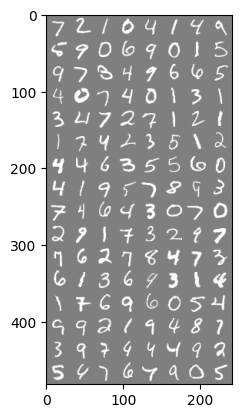

GroundTruth:  7     2     1     0    


In [32]:
# adapted from training a classifier documentation on the pytorch website
import numpy as np 
from typing import Tuple

dataiter = iter(test_dataloader)
images, labels = next(dataiter)

# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# define all classes
classes: Tuple[int, ...] = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)
# print images
imshow(torchvision.utils.make_grid(images))
# get the classification for the first 4 items
print('GroundTruth: ', ' '.join(f'{str(classes[labels[j]]):5s}' for j in range(4)))

In [33]:
# compare to what the neural network things
outputs = nonlinear_model(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{str(classes[predicted[j]]):5s}'
                              for j in range(4)))

Predicted:  7     2     1     0    


In [34]:
# test accuracy on test data set
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = nonlinear_model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 96 %
